## Домашнее задание

UMAP (и библиотека openTSNE) позволяют к уже существующей модели снижения размерности добавлять новые точки. Попробуйте разобраться, каким именно образом можно сохранить модель UMAP, которая используется в scanpy, чтобы использовать в дальнейшем для добавления новых клеток.

Можете начать с openTSNE, однако в случае с UMAP это актуальнее. Можете рассмотреть, каким образом точки добавляются на эмбеддинг в случае с методом `sc.tl.ingest` (<a href="https://github.com/scverse/scanpy/blob/3d597046ac81a7f8c305cfa20594d8ecaba11fb8/scanpy/tools/_ingest.py">ссылка на код</a>), но можете также и поступить проще, просто сохранив модель.

## Решение

In [ ]:
!pip3 install scanpy[leiden] anndata2ri scikit-misc scvi-tools opentsne

import os
os.kill(os.getpid(), 9)

In [52]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
sns.set_style("ticks")

В первую очередь загрузим scRNA-seq данные и инициализируем переменные c изначальными данными и добавляемыми данными.

In [37]:
adding_cells_counts = 2000
adata = sc.datasets.pbmc3k()
old_adata = adata[:(2700-adding_cells_counts), :]
adata_to_add = adata[(2700-adding_cells_counts):2700, :]

Размер изначального adata составляет 700 клеток на 32738 генов.

In [38]:
old_adata

View of AnnData object with n_obs × n_vars = 700 × 32738
    var: 'gene_ids'

Размер добавляемого adata: 2000 клеток на 32738 генов.

In [39]:
adata_to_add

View of AnnData object with n_obs × n_vars = 2000 × 32738
    var: 'gene_ids'

Создадим две функции, одна из которых инициализирует open tSNE координаты в adata датасете, другая функция добавляет новые координаты кластеров к уже существующему датасету.

In [40]:
from openTSNE import TSNE

def init_openTSNE(adata):
    '''
    This function add open tSNE
    coordinates to an adata.
    '''
    adata_with_tsne = adata.copy()
    tsne = TSNE(perplexity=30, exaggeration=1, verbose=True)
    adata_with_tsne.obsm["X_open_tsne"] = tsne.fit(adata_with_tsne.obsm["X_pca"])
    return adata_with_tsne

In [41]:
def add_new_adata(old_adata, adata_for_adding):
    '''
    This function adds a new adata 
    to an existing adata and returns
    concatenated adata.
    '''
    # calculating new points coordinates by old adata dataset
    adata_for_adding.obsm['X_pca'] = adata_for_adding.X @ old_adata.varm['PCs'] 

    # transform to the X_open_tsne
    adata_for_adding.obsm['X_open_tsne'] = old_adata.obsm["X_open_tsne"].transform(adata_for_adding.obsm['X_pca']) 

    # concatenate old and new adata datasets
    updated_adata = old_adata.concatenate(adata_for_adding)
    
    return updated_adata

Отшкалируем изначальные данные и рассчитаем PCA для них

In [42]:
sc.pp.scale(old_adata)
sc.tl.pca(old_adata, n_comps=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50


/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:04)


In [43]:
old_adata

AnnData object with n_obs × n_vars = 700 × 32738
    var: 'gene_ids', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Отшкалируем добавляемый датасет

In [44]:
sc.pp.scale(adata_to_add)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Добавим в первоначальный adata координаты open tSNE

In [45]:
old_adata_with_openTSNE = init_openTSNE(old_adata)

--------------------------------------------------------------------------------
TSNE(exaggeration=1, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.03 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.07 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.7293, 50 iterations in 0.3404 sec
Iteration  100, KL divergence 2.3713, 50 iterations in 0.1992 sec
Iteration  150, KL divergence 2.3586, 50 iterations in 0.2025 sec
Iteration  200, KL divergence 2.3581, 50 iterations in 0.2037 sec
Iteration  250, KL divergence 2.3586, 50 iterations in 0.1910 sec
   --> Time elapsed: 1.14 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration 

In [46]:
old_adata_with_openTSNE

AnnData object with n_obs × n_vars = 700 × 32738
    var: 'gene_ids', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca', 'X_open_tsne'
    varm: 'PCs'

In [47]:
old_adata_with_openTSNE.obsm

AxisArrays with keys: X_pca, X_open_tsne

Добавим к первоначальному adata новый adata:

In [48]:
updated_adata = add_new_adata(old_adata_with_openTSNE, adata_to_add)

===> Finding 15 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.05 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 20164.9275, 50 iterations in 0.4324 sec
Iteration  100, KL divergence 20148.1923, 50 iterations in 0.4276 sec
Iteration  150, KL divergence 20145.7850, 50 iterations in 0.4206 sec
Iteration  200, KL divergence 20144.6371, 50 iterations in 0.4242 sec
Iteration  250, KL divergence 20141.7617, 50 iterations in 0.4104 sec
   --> Time elapsed: 2.12 seconds


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Теперь размер adata составляет 2700 клеток (2695 клеток первоначального датасета и 5 клеток нового)

In [49]:
updated_adata.obsm["X_open_tsne"].shape

(2700, 2)

На графика ниже можно заметить, как отличается кластеризация данных c помощью open tSNE до и после добавления новых данных.

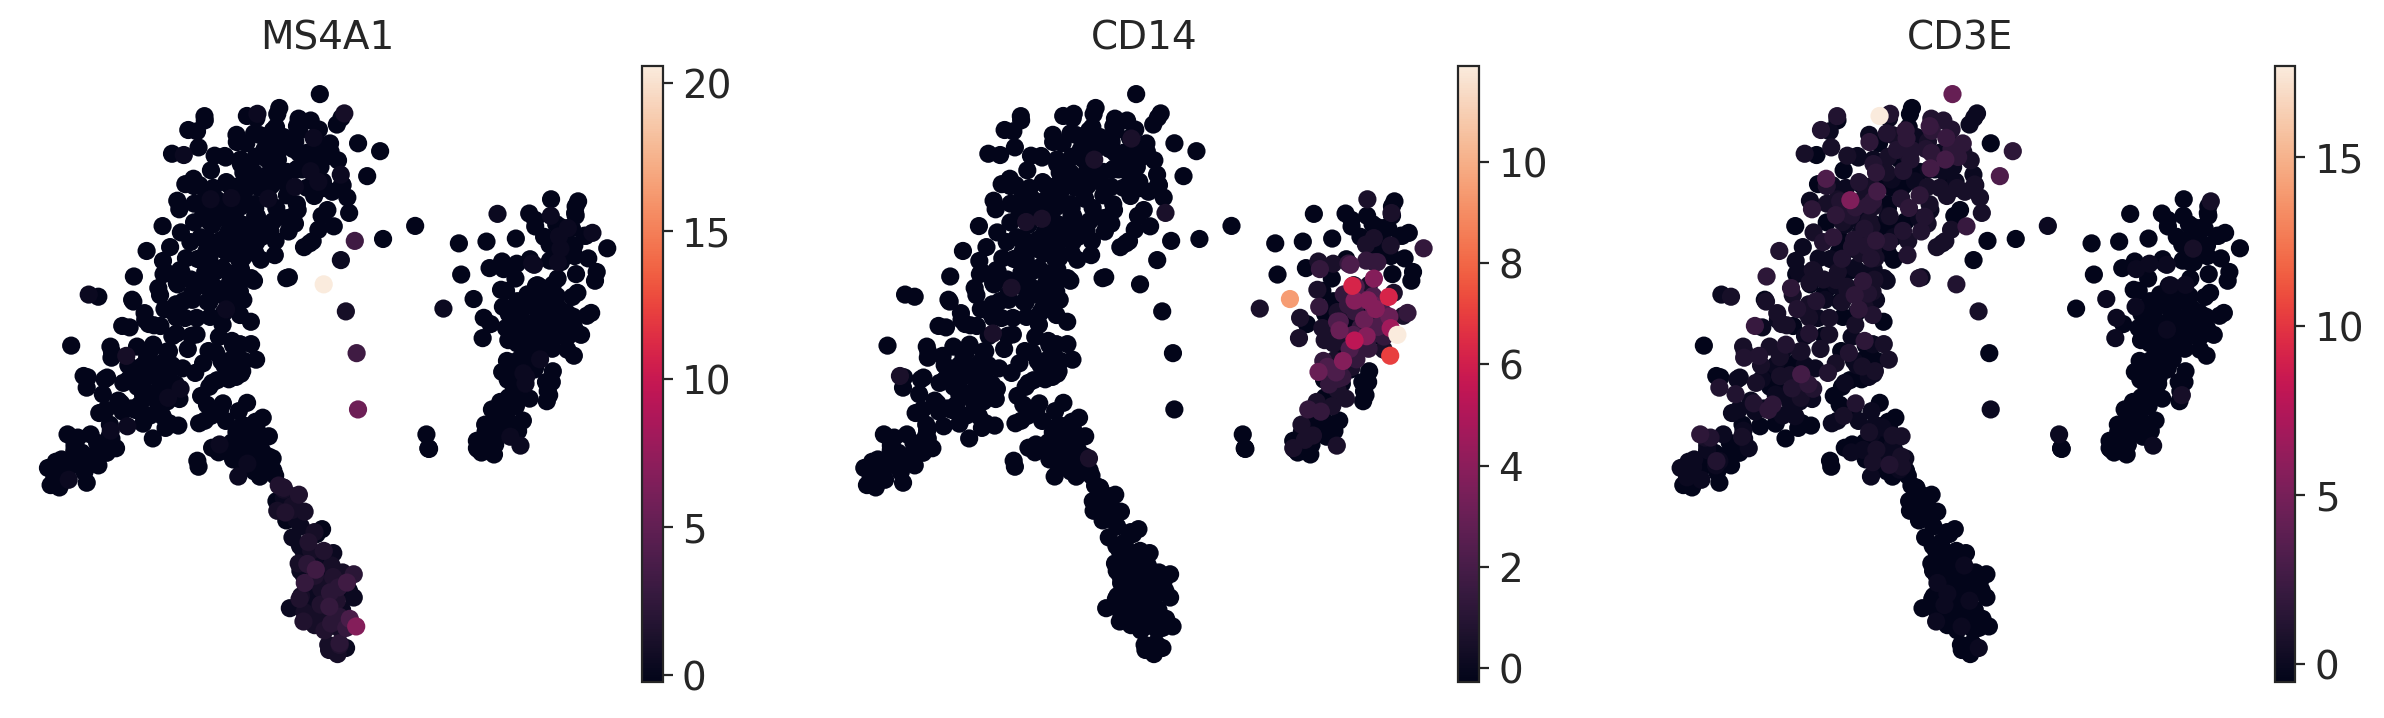

In [59]:
sc.pl.embedding(old_adata_with_openTSNE, basis="X_open_tsne", color=["MS4A1", "CD14", "CD3E"], frameon=False)

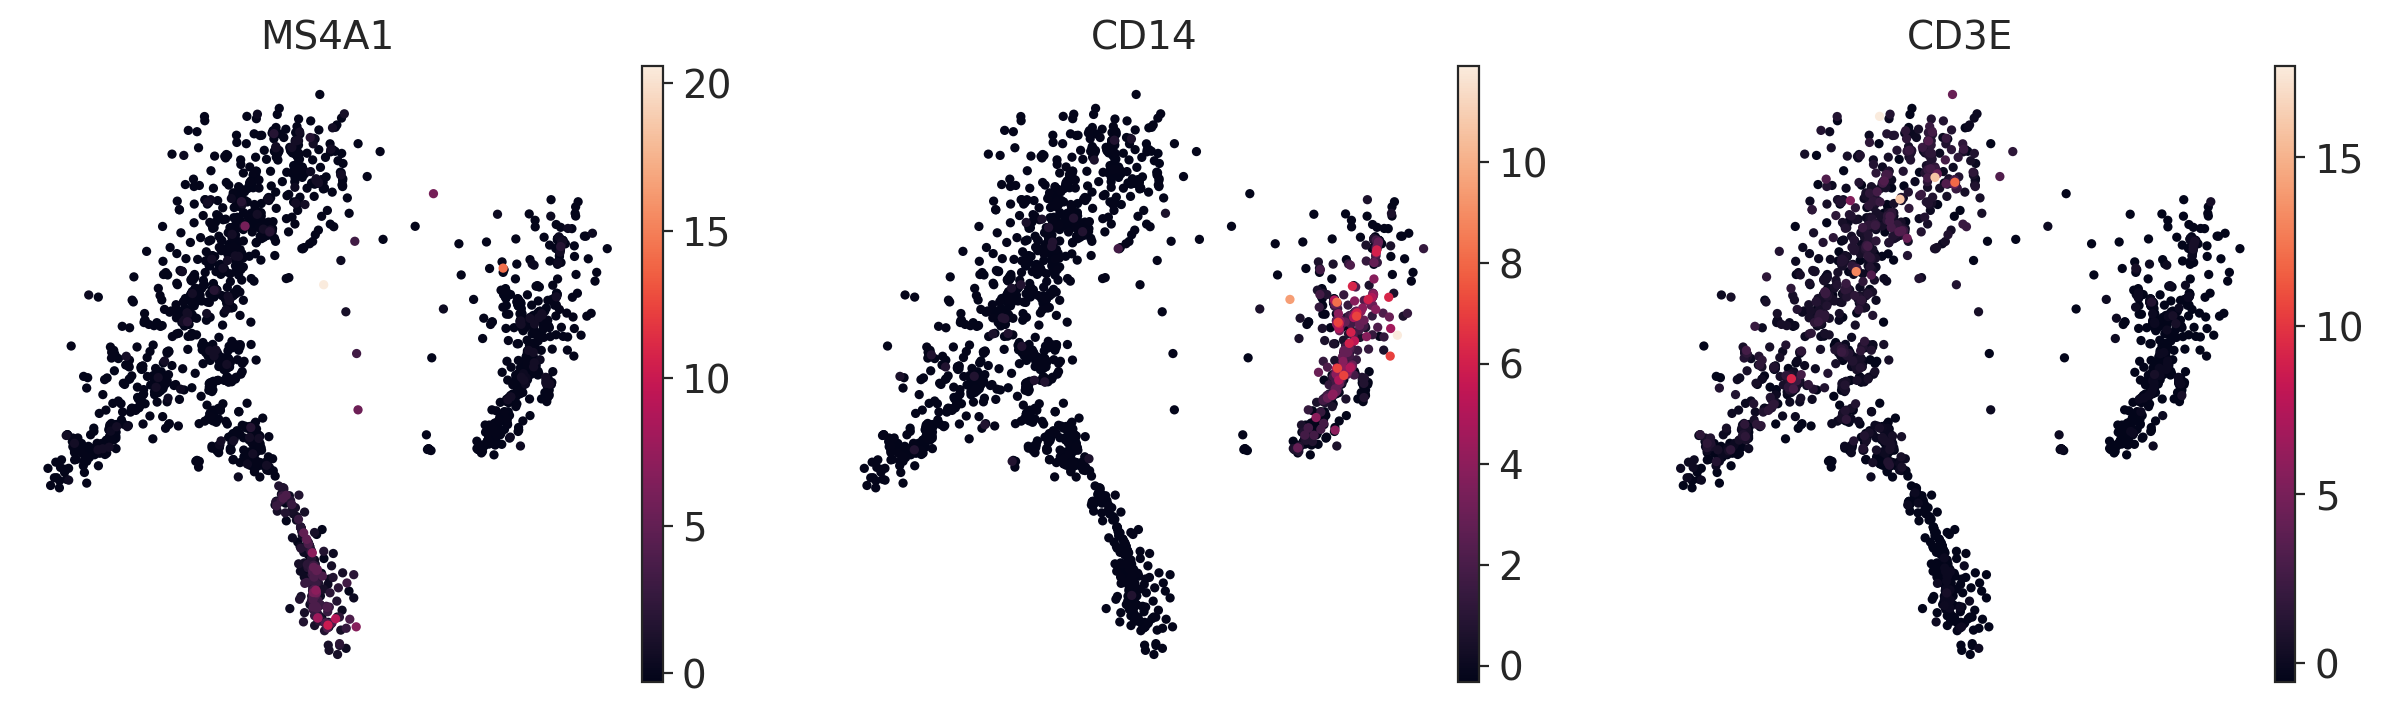

In [60]:
sc.pl.embedding(updated_adata, basis="X_open_tsne", color=["MS4A1", "CD14", "CD3E"], frameon=False)